In [1]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats
import cmocean

from plotting import plot_utils, summary_plots, load_fits
from utils import roi_utils, default_paths, prf_utils
from feature_extraction import gabor_feature_extractor
import copy

#### Load fit results

In [2]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type1 = 'gabor_solo_ridge_12ori_8sf'
out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type1, n_from_end=0, \
                                  verbose=False) for ss in subjects]

fitting_type2 = 'gabor_solo_ridge_12ori_8sf_permutation_test'
out_shuff = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type2, n_from_end=0, \
                                  verbose=False) \
       for ss in subjects]

fitting_type3 = 'gabor_solo_ridge_12ori_8sf_from_residuals'
out_resid = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type3, n_from_end=0, \
                                  verbose=False) \
       for ss in subjects]

fitting_type4 = 'gabor_solo_ridge_12ori_8sf_from_residuals_permutation_test'
out_resid_shuff = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type4, n_from_end=0, \
                                  verbose=False) \
       for ss in subjects]

# make a list of voxels per subject
n_vox_each_subj = [out[si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

#### Process results of permutation test, compute p-values

In [3]:
from utils import stats_utils
from plotting import summary_plots

p_voxels_orig = [[] for si in range(n_subjects)]
p_voxels_resid = [[] for si in range(n_subjects)]

for si in range(n_subjects):

    # stats for single voxels
    r2_real_orig = out[si]['val_r2']
    r2_shuff_orig = out_shuff[si]['val_r2']

    # for how many of the shuffle iterations did shuffle-R2 exceed real-R2?
    p_orig = np.mean(r2_real_orig[:,0,None]<=r2_shuff_orig[:,0,:], axis=1)
    _,pvals_fdr_orig = stats_utils.fdr_keepshape(p_orig, alpha=0.01, \
                                                   method='poscorr')
    p_voxels_orig[si] = pvals_fdr_orig
    
    # stats for single voxels
    r2_real_resid = out_resid[si]['val_r2']
    r2_shuff_resid = out_resid_shuff[si]['val_r2']

    # for how many of the shuffle iterations did shuffle-R2 exceed real-R2?
    p_resid = np.mean(r2_real_resid[:,0,None]<=r2_shuff_resid[:,0,:], axis=1)
    _,pvals_fdr_resid = stats_utils.fdr_keepshape(p_resid, alpha=0.01, \
                                                   method='poscorr')
    p_voxels_resid[si] = pvals_fdr_resid
     

In [4]:
sig_orig = np.concatenate(p_voxels_orig, axis=0)<0.01
sig_resid = np.concatenate(p_voxels_resid, axis=0)<0.01
abv_thresh = sig_orig & sig_resid

#### Get info about the Gabor feature space

In [6]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


#### Organize the feature sensitivity matrices
feature sensitivity = corr coef between model resp and feature channel activation

In [7]:
feature_corr1 = np.concatenate([out[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr1.shape[0]
allcorr_reshaped1 = np.reshape(feature_corr1, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr1 = np.mean(allcorr_reshaped1, axis=2)
mean_sf_corr1 = np.mean(allcorr_reshaped1, axis=1)

# find maxes across orient/SF.
preferred_ori_corr1 = np.argmax(mean_orient_corr1, axis=1).astype(np.float32)
is_constant1 = np.all(np.tile(mean_orient_corr1[:,0:1], [1,n_ori])==mean_orient_corr1, axis=1)
assert(not(np.any(is_constant1)))

preferred_sf_corr1 = np.argmax(mean_sf_corr1, axis=1).astype(np.float32)
is_constant1 = np.all(np.tile(mean_sf_corr1[:,0:1], [1,n_sf])==mean_sf_corr1, axis=1)
assert(not(np.any(is_constant1)))

feature_corr2 = np.concatenate([out_resid[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr2.shape[0]
allcorr_reshaped2 = np.reshape(feature_corr2, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr2 = np.mean(allcorr_reshaped2, axis=2)
mean_sf_corr2 = np.mean(allcorr_reshaped2, axis=1)

preferred_ori_corr2 = np.argmax(mean_orient_corr2, axis=1).astype(np.float32)
is_constant2 = np.all(np.tile(mean_orient_corr2[:,0:1], [1,n_ori])==mean_orient_corr2, axis=1)
assert(not(np.any(is_constant2)))

preferred_sf_corr2 = np.argmax(mean_sf_corr2, axis=1).astype(np.float32)
is_constant2 = np.all(np.tile(mean_sf_corr2[:,0:1], [1,n_sf])==mean_sf_corr2, axis=1)
assert(not(np.any(is_constant2)))


In [8]:
n_vox = preferred_ori_corr1.shape[0]
feature_prefs_2dhist_orig = np.zeros((n_vox, n_ori, n_sf))
feature_prefs_2dhist_resid = np.zeros((n_vox, n_ori, n_sf))
for vv in range(n_vox):
    oo = int(preferred_ori_corr1[vv])
    ff = int(preferred_sf_corr1[vv])
    feature_prefs_2dhist_orig[vv,oo,ff] = 1
    oo = int(preferred_ori_corr2[vv])
    ff = int(preferred_sf_corr2[vv])
    feature_prefs_2dhist_resid[vv,oo,ff] = 1

In [16]:
sem_group_names

array(['face', 'not', 'building', 'not', 'animate', 'inanimate', 'small',
       'large', 'indoor', 'outdoor'], dtype='<U9')

#### Define pseudo-ROIs based on semantic selectivity

In [53]:
fitting_type = 'semantic_discrim_raw_trnval_all'

out = [load_fits.load_fit_results(ss, fitting_type,n_from_end=0,verbose=False) for ss in subjects]        

n_discrim_types = len(out[0]['discrim_type_list'])
assert(len(out[0]['axes_to_do_partial'])==n_discrim_types)
signed_names = out[0]['discrim_type_list']
n_dims = len(signed_names)

sem_group_names = np.array([n.split(' vs ') if 'vs' in n else n.split('-') for n in signed_names]).ravel()
n_sem_groups = len(sem_group_names)

p_thresh = 0.01

sem_tvals = [[] for ss in subjects]
sem_pvals = [[] for ss in subjects]
sem_groups = [[] for ss in subjects]

which_axes_negate = [0,1,2,3,4]

min_samp = 5

for si, ss in enumerate(subjects):
    
    # load the semantic selectivity results for each voxel
    out_sem = out[si]
    
    t = copy.deepcopy(out_sem['sem_discrim_each_axis'])
    t[:,which_axes_negate] *= (-1)
    sem_tvals[si] = t
    
    # compute the p-value for each t-statistic, based on the degrees of freedom
    # (number of samples)
    nsamp = out_sem['n_sem_samp_each_axis']
    bad_nsamp = (nsamp<min_samp) | np.isnan(nsamp)
    vox_exclude = np.any(np.any(bad_nsamp, axis=2), axis=1)
    print(np.mean(~vox_exclude))
    
    df = nsamp[:,:,0]+nsamp[:,:,1]-2
    # two-tailed test, multiply by 2
    p = scipy.stats.t.sf(np.abs(t), df)*2

    sem_pvals[si] = p;   
    
    n_vox = p.shape[0]
    sem_groups[si] = np.zeros((n_vox, n_dims*2))
    
    gg=-1
    for dim in range(n_dims):
        
        gg+=1
        sem_groups[si][:,gg] = (p[:,dim]<p_thresh) & (t[:,dim]>0) & ~vox_exclude
        gg+=1
        sem_groups[si][:,gg] = (p[:,dim]<p_thresh) & (t[:,dim]<0) & ~vox_exclude
            

1.0
1.0
0.9987500624968751
0.9991222937390287
0.9987576968780383
0.9995388304740823
1.0
0.9940722210137046


In [42]:
# going to exclude early visual areas from the pseudo-ROIs so that they are only higher vis cortex
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = len(roi_names)
print(roi_names[0:4])

early_visual_mask = np.any(np.array([roi_def.get_indices(ii) for ii in range(4)]), axis=0)
np.shape(early_visual_mask)

['V1', 'V2', 'V3', 'hV4']


(150842,)

In [69]:
avg_resp_profiles_orig = np.zeros((n_subjects, n_sem_groups, n_ori, n_sf))
avg_resp_profiles_resid = np.zeros((n_subjects, n_sem_groups, n_ori, n_sf))

for ri in range(n_sem_groups): 
    
    sem_group_inds = (np.concatenate([sem_groups[si][:,ri] for si in range(n_subjects)], axis=0)==1) &\
                    abv_thresh \
                    &(~early_visual_mask)
    print(np.sum(sem_group_inds))
    
    for si in range(n_subjects):
        
        inds_use = sem_group_inds & (subject_inds==si)
        
        avg_resp_profiles_orig[si,ri,:,:] = np.mean(allcorr_reshaped1[inds_use,:,:], axis=0)
        avg_resp_profiles_resid[si,ri,:,:] = np.mean(allcorr_reshaped2[inds_use,:,:], axis=0)

15978
18059
13984
18144
13788
20644
21640
9448
22031
10884


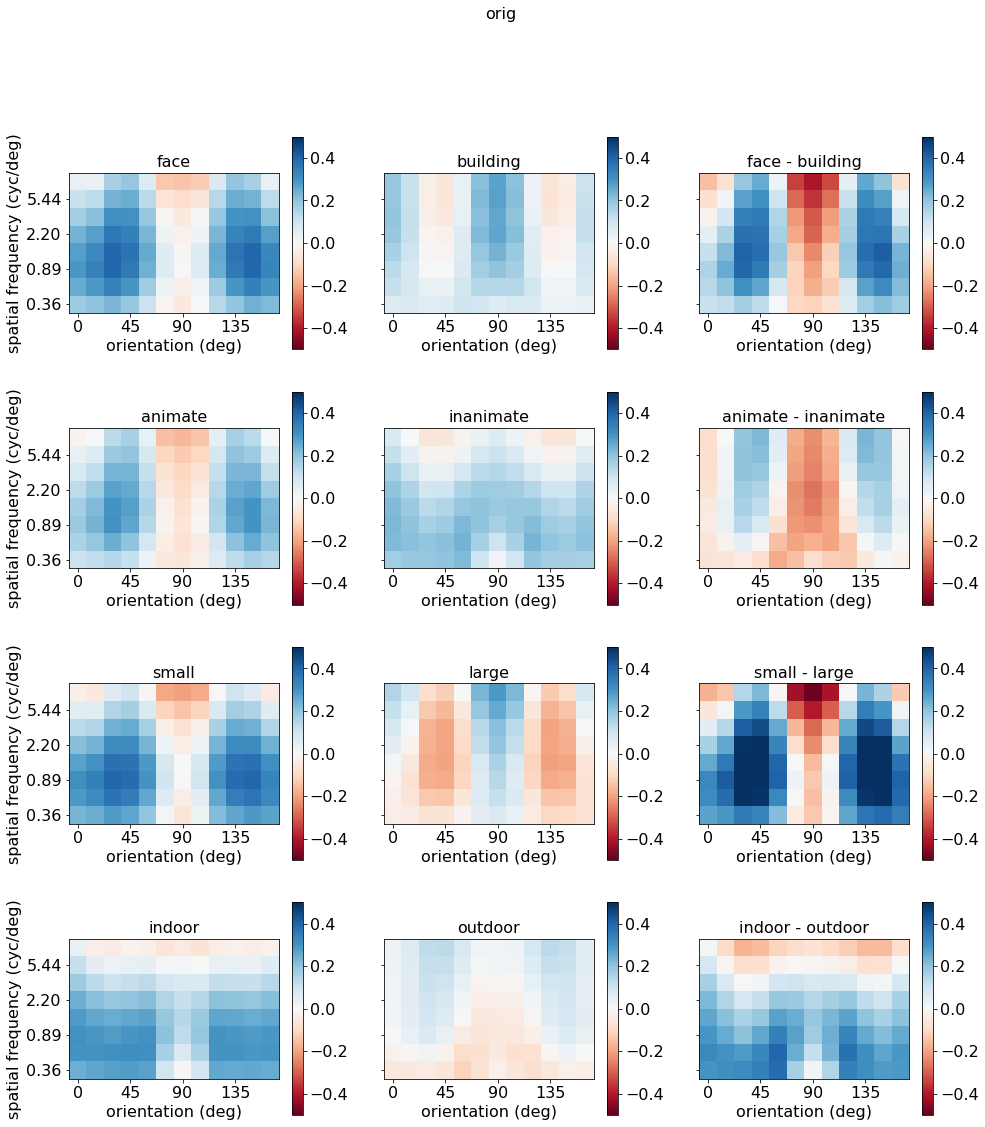

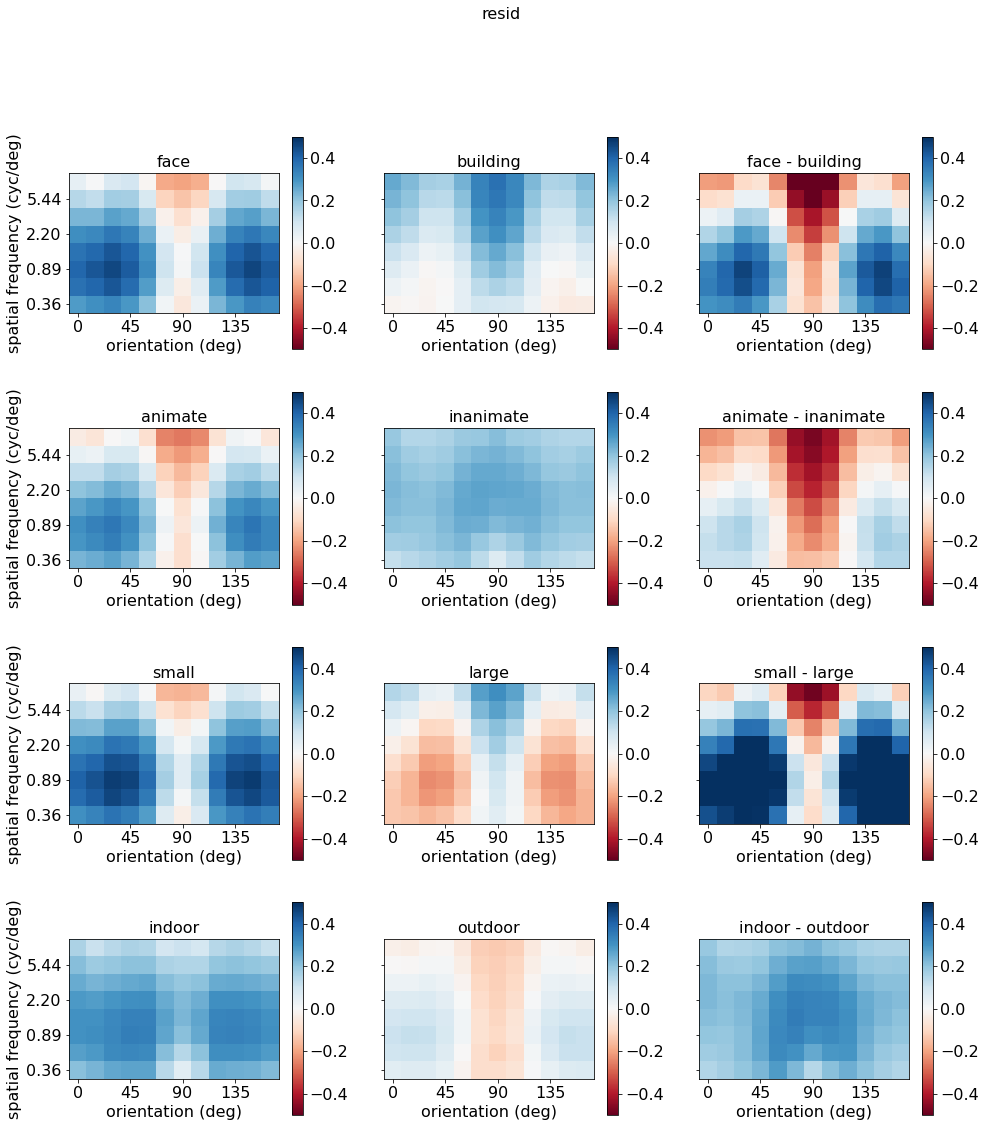

In [70]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

for rname, respvals in zip(['orig','resid'], [avg_resp_profiles_orig, avg_resp_profiles_resid]):

    plt.figure(figsize=(16,18))
    # npy = int(np.ceil(np.sqrt(n_sem_groups)))
    # npx = int(np.ceil((n_sem_groups)/npy))

    pi=0

    clims = [-0.5, 0.5]

    # pairs = [[0,1],[2,3],[4,5],[6,7],[8,9]]
    pairs = [[0,2],[4,5],[6,7],[8,9]]

    for pair in pairs:

        for xx in [0,1,2]:

            pi+=1
            plt.subplot(4,3,pi)

            # print(pair[xx])
            
            if xx<2:
                vals = np.mean(respvals[:,pair[xx],:,:], axis=0)
                name = sem_group_names[pair[xx]]
            else:
                vals = np.mean(respvals[:,pair[0],:,:] - respvals[:,pair[1],:,:], axis=0)
                name = '%s - %s'%(sem_group_names[pair[0]], sem_group_names[pair[1]])

            plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.RdBu)

            plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
            sf_ticks = sf_unique[[0,2,4,6]].round(2)
            if xx==0:
                plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
                plt.ylabel('spatial frequency (cyc/deg)')
            else:
                plt.yticks(np.array([0,2,4,6])+0.5,[])
            plt.axis('square')
            plt.xlim([0,12])
            plt.ylim([0,8])
            # plt.axis('off')
            plt.colorbar()

            plt.xlabel('orientation (deg)')
            # else:
            #     plt.yticks(np.array([0,2,4,6])+0.5, [])

            plt.title(name)

    plt.suptitle(rname)
# plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out_orig))

# fn2save = os.path.join(default_paths.fig_path, 'Orient_sensitivity_allareas.pdf')
# plt.savefig(fn2save)

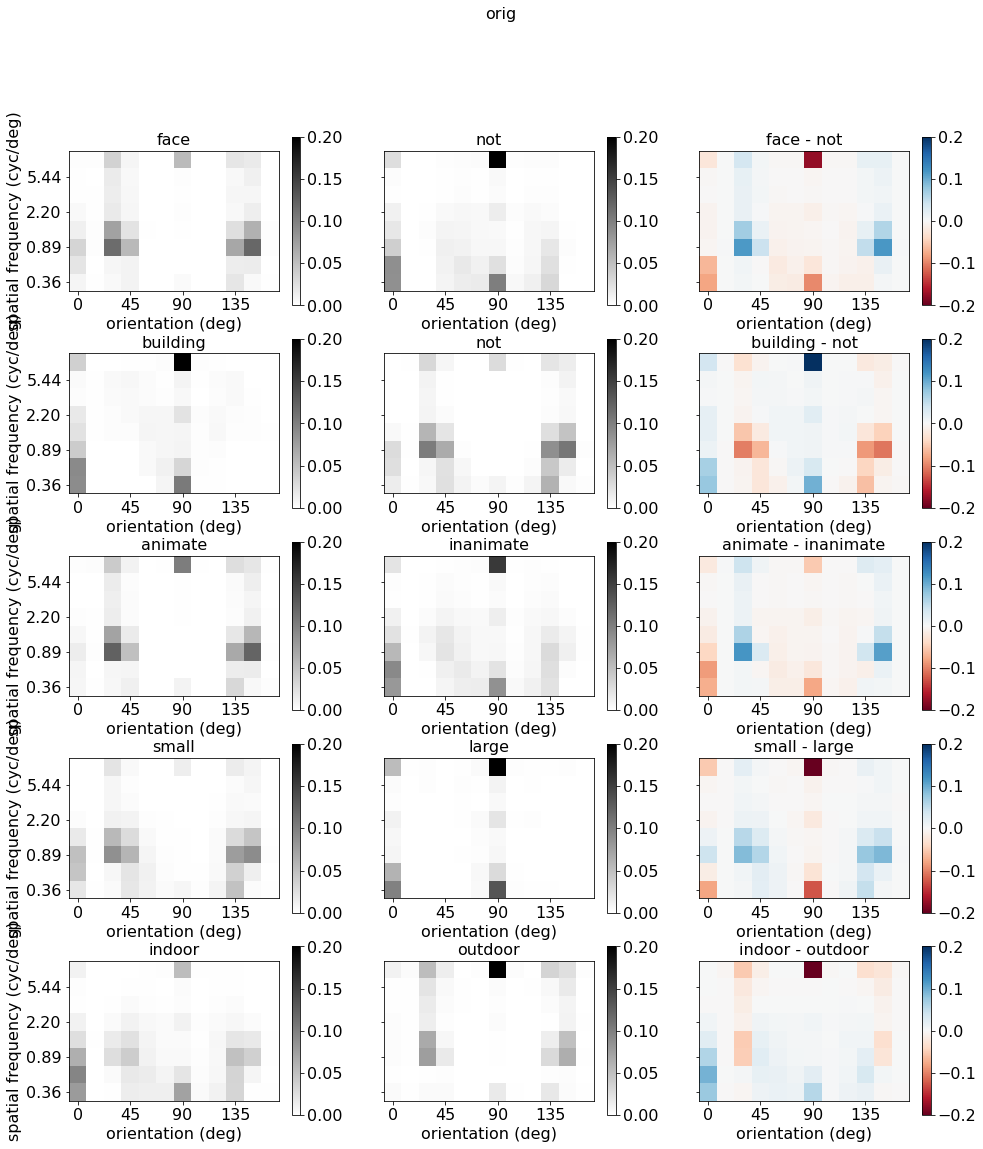

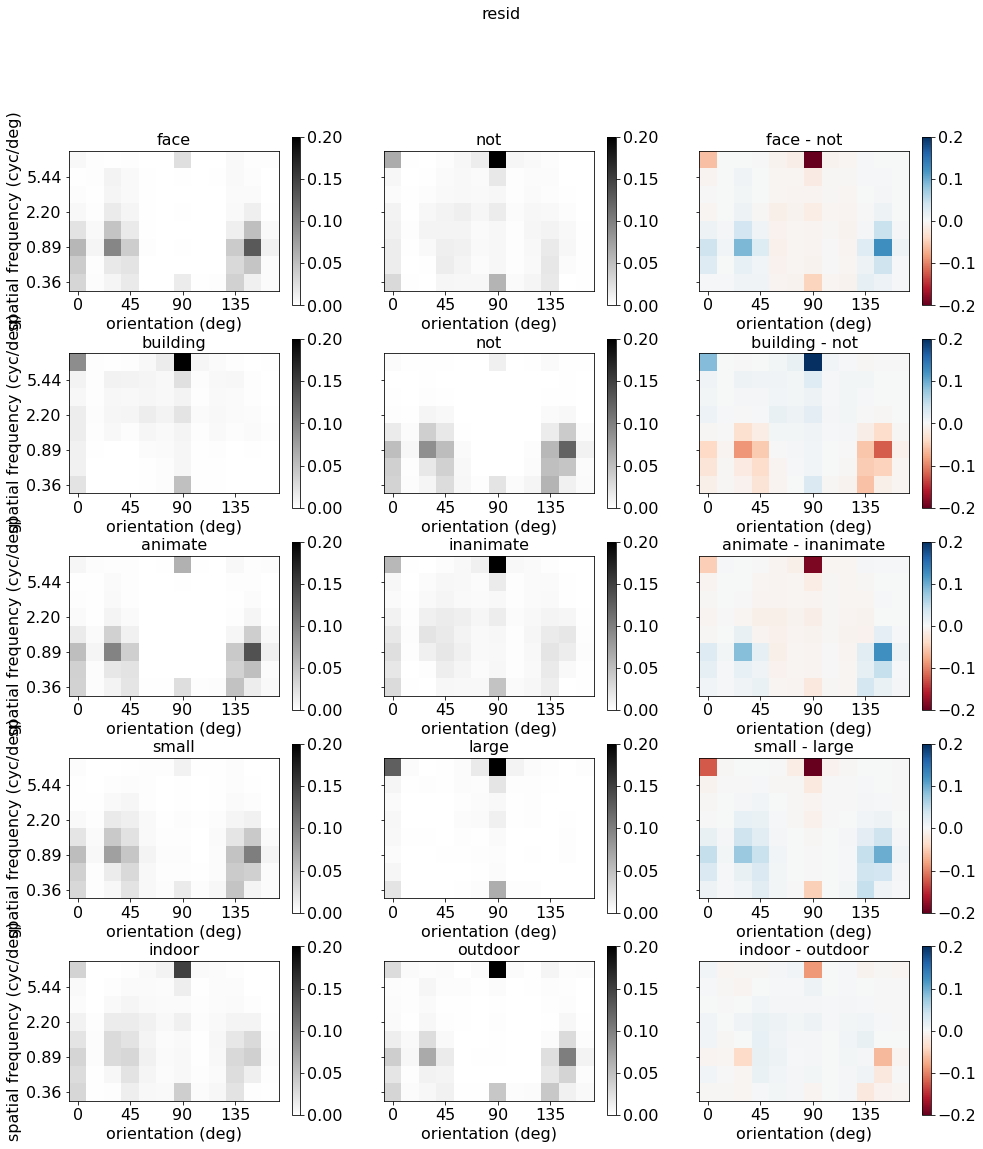

In [60]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

for hname, histvals in zip(['orig','resid'],[feature_prefs_2dhist_orig, feature_prefs_2dhist_resid]):

    plt.figure(figsize=(16,18))

    pi=0

    clims = [0, 0.20]

    pairs = [[0,1],[2,3],[4,5],[6,7],[8,9]]

    for pair in pairs:

        rr = pair[0]
        sem_group_inds = (np.concatenate([sem_groups[si][:,rr] for si in range(n_subjects)], axis=0)==1) &\
                    abv_thresh &\
                    (~early_visual_mask)
        
        vals1 = np.mean(histvals[sem_group_inds,:,:], axis=0)

        rr = pair[1]
        sem_group_inds = (np.concatenate([sem_groups[si][:,rr] for si in range(n_subjects)], axis=0)==1) &\
                    abv_thresh &\
                    (~early_visual_mask)

        vals2 = np.mean(histvals[sem_group_inds,:,:], axis=0)

        for xx in [0,1,2]:

            pi+=1
            plt.subplot(5,3,pi)

            if xx==0:
                vals = vals1;
                name = sem_group_names[pair[0]]
                plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.gray_r)

            elif xx==1:
                vals = vals2;
                name = sem_group_names[pair[1]]
                plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.gray_r)

            else:
                vals = vals1 - vals2;
                name = '%s - %s'%(sem_group_names[pair[0]],sem_group_names[pair[1]])
                plt.pcolormesh(vals.T,  vmin=-0.2, vmax=0.2, cmap=cm.RdBu)

            plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
            sf_ticks = sf_unique[[0,2,4,6]].round(2)
            if xx==0:
                plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
                plt.ylabel('spatial frequency (cyc/deg)')
            else:
                plt.yticks(np.array([0,2,4,6])+0.5,[])
            plt.axis('square')
            plt.xlim([0,12])
            plt.ylim([0,8])

            plt.colorbar()
            plt.xlabel('orientation (deg)')
            plt.title(name)

    plt.suptitle(hname)
    

#### Load image stats analysis

In [13]:
from analyze_features import load_feature_stats
from model_fitting import initialize_fitting 

feature_type='gabor_solo'
subject=999

mean, var, covar = \
        load_feature_stats.load_feature_stats(feature_type, subject=subject)

partial_corr, partial_nsamp, partial_names, partial_signed_names = \
        load_feature_stats.load_feature_semantic_partial_corrs(feature_type, subject=subject,\
                                                               which_axes_negate = [0,1,2],
                                                       min_samp=20, verbose=True)

n_partial_discrim_types = partial_corr.shape[2]
axes_to_do_partial = [0,2,3]

models = initialize_fitting.get_prf_models(which_grid=5)
n_prfs = len(models)

mean_reshaped = np.reshape(mean, [n_ori, n_sf, n_prfs], order = 'F')
var_reshaped = np.reshape(var, [n_ori, n_sf, n_prfs], order = 'F')
 
sem_corr_reshaped = np.reshape(partial_corr, [n_ori, n_sf, n_prfs, len(axes_to_do_partial)], order='F')

In [14]:
partial_signed_names

['indoor > outdoor', 'animate > inanimate', 'small > large']

#### Correlate each voxel's sensitivity profile with the diagnostic feature channels for each semantic axis

In [16]:
n_vox = allcorr_reshaped1.shape[0]
n_dims = n_partial_discrim_types
tuning_dim_corrs = np.zeros((n_vox,n_dims))
tuning_var_corrs = np.zeros((n_vox,))
tuning_mean_corrs = np.zeros((n_vox,))

for vv in range(n_vox):
    
    if np.mod(vv,5000)==0:
        print('%d/%d'%(vv, n_vox))
        
    # selectivity of the current voxel for each channel
    vox_vals = allcorr_reshaped1[vv,:,:].ravel()
        
    # prf_ind = vox_prf_inds[vv]
    
    # mean_vals = mean_reshaped[:,:,prf_ind].ravel()
    # var_vals = var_reshaped[:,:,prf_ind].ravel()
    mean_vals = np.mean(mean_reshaped, axis=2).ravel()
    var_vals = np.mean(var_reshaped, axis=2).ravel()
    
    tuning_mean_corrs[vv] = np.corrcoef(mean_vals, vox_vals)[0,1]
    tuning_var_corrs[vv] = np.corrcoef(var_vals, vox_vals)[0,1]
    
    for dim in range(n_dims):
        
        # sem_vals = sem_corr_reshaped[:,:,prf_ind,dim].ravel()
        sem_vals = np.mean(sem_corr_reshaped[:,:,:,dim], axis=2).ravel()

        # raw correlation
        tuning_dim_corrs[vv,dim] = np.corrcoef(sem_vals, vox_vals)[0,1]

0/150842
5000/150842
10000/150842
15000/150842
20000/150842
25000/150842
30000/150842
35000/150842
40000/150842
45000/150842
50000/150842
55000/150842
60000/150842
65000/150842
70000/150842
75000/150842
80000/150842
85000/150842
90000/150842
95000/150842
100000/150842
105000/150842
110000/150842
115000/150842
120000/150842
125000/150842
130000/150842
135000/150842
140000/150842
145000/150842
150000/150842


In [17]:
roi_tuning_mean_corrs = np.zeros((n_subjects, n_sem_groups))
roi_tuning_var_corrs = np.zeros((n_subjects, n_sem_groups))
roi_tuning_dim_corrs = np.zeros((n_subjects, n_sem_groups, n_dims))

for si in range(n_subjects):
    
    for ri in range(n_sem_groups):
        
        inds_this_roi = np.concatenate([sem_groups[si][:,ri] \
                            for si in range(n_subjects)], axis=0)==1
        inds_this_roi = inds_this_roi & abv_thresh & (subject_inds==si)   
       
        roi_tuning_mean_corrs[si,ri] = np.mean(tuning_mean_corrs[inds_this_roi], axis=0)
        roi_tuning_var_corrs[si,ri] = np.mean(tuning_var_corrs[inds_this_roi], axis=0)
        roi_tuning_dim_corrs[si,ri,:] = np.mean(tuning_dim_corrs[inds_this_roi,:], axis=0)


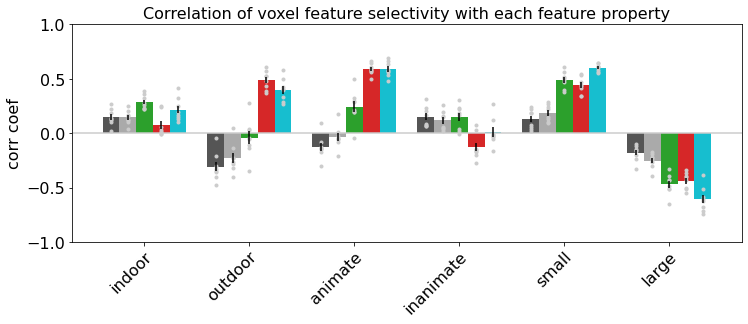

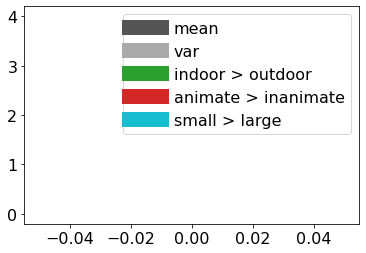

In [18]:
colors = cm.tab10(np.linspace(0,1,10))[[2, 3, 9],:]
colors_gray = cm.gray(np.linspace(0,1,4))[1:3,:]
colors = np.concatenate([colors_gray, colors], axis=0)

roi_mean_vals = np.concatenate([roi_tuning_mean_corrs[:,:,None], \
                                roi_tuning_var_corrs[:,:,None], \
                                roi_tuning_dim_corrs], axis=2)
# roi_mean_vals = np.concatenate([roi_tuning_mean_corrs2[:,:,None], \
#                                 roi_tuning_var_corrs2[:,:,None], \
#                                 roi_tuning_dim_corrs2], axis=2)

mean_vals = np.mean(roi_mean_vals, axis=0)
sem_vals = np.std(roi_mean_vals, axis=0)/np.sqrt(n_subjects)

legend_separate = True
plot_utils.set_all_font_sizes(16)

plt.rcParams['pdf.fonttype']=42
title='Correlation of voxel feature selectivity with each feature property'

bw = 0.16;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data = roi_mean_vals, \
                                colors=colors, space=space, \
            xticklabels=sem_group_names, ylabel='corr coef', \
            ylim=[-1.0, 1.0], title=title, horizontal_line_pos=0,\
            legend_labels=['mean','var']+partial_signed_names, \
            legend_overlaid=False, legend_separate=True, \
            fig_size=(12,4))

# fn2save = os.path.join(default_paths.fig_path, 'Semantic_selectivity_signed_ROIavg.pdf')
# plt.savefig(fn2save)